In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [ ]:
# !unzip ./data.zip -d ./data

In [ ]:
from torchvision import datasets, transforms

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root='./data/train', transform=data_transforms)


In [ ]:
from torchvision import models

def create_model(num_classes):
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    return model


In [ ]:
import torch
import time
import copy
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    since = time.time()
    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)


                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history


In [ ]:
from torch.utils.data import DataLoader, Subset

dataset_size = len(dataset)
indices = torch.randperm(dataset_size).tolist()
subset_indices = indices[:int(0.01 * dataset_size)]
subset = Subset(dataset, subset_indices)
data_loader = DataLoader(subset, batch_size=32, shuffle=True)

In [ ]:
### RUN FOR FULL DATA (Will take approx 2 hours)

# from sklearn.model_selection import StratifiedKFold
# from torch.utils.data import Subset, DataLoader
# import numpy as np
# import torch
# import torch.optim as optim

# labels = np.array([label for _, label in dataset.samples])

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# results = []

# for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
#     print(f'Fold {fold + 1}')

#     train_subset = Subset(dataset, train_idx)
#     val_subset = Subset(dataset, val_idx)
#     train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
#     val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
#     dataloaders = {'train': train_loader, 'val': val_loader}

#     # Initialize the model for this fold
#     model = create_model(num_classes=len(dataset.classes))
#     model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     # Train and evaluate the model
#     fold_result = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
#     results.append(fold_result)


# data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
### RUN FOR SUBSET OF DATA

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch
import torch.optim as optim

labels = [dataset.targets[i] for i in subset_indices]
labels = np.array(labels)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f'Fold {fold + 1}')

    train_subset = Subset(subset, train_idx)
    val_subset = Subset(subset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    dataloaders = {'train': train_loader, 'val': val_loader}

    model = create_model(num_classes=len(dataset.classes))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    fold_result = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
    results.append(fold_result)


Fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


 10%|█         | 1/10 [00:01<00:13,  1.55s/it]

Train Loss: 1.9279 Acc: 0.2445
Val Loss: 3.7096 Acc: 0.2586

Epoch 2/10
----------


 20%|██        | 2/10 [00:02<00:11,  1.46s/it]

Train Loss: 1.1627 Acc: 0.5808
Val Loss: 2.0473 Acc: 0.3621

Epoch 3/10
----------


 30%|███       | 3/10 [00:04<00:09,  1.42s/it]

Train Loss: 0.6871 Acc: 0.7598
Val Loss: 2.4755 Acc: 0.2759

Epoch 4/10
----------


 40%|████      | 4/10 [00:05<00:08,  1.41s/it]

Train Loss: 0.4243 Acc: 0.8428
Val Loss: 2.9764 Acc: 0.3793

Epoch 5/10
----------


 50%|█████     | 5/10 [00:07<00:07,  1.41s/it]

Train Loss: 0.2474 Acc: 0.9258
Val Loss: 2.4561 Acc: 0.3966

Epoch 6/10
----------


 60%|██████    | 6/10 [00:08<00:05,  1.40s/it]

Train Loss: 0.3162 Acc: 0.9127
Val Loss: 3.2513 Acc: 0.3103

Epoch 7/10
----------


 70%|███████   | 7/10 [00:09<00:04,  1.39s/it]

Train Loss: 0.4034 Acc: 0.8734
Val Loss: 3.2923 Acc: 0.3793

Epoch 8/10
----------
Train Loss: 0.2809 Acc: 0.9214


 80%|████████  | 8/10 [00:11<00:02,  1.44s/it]

Val Loss: 4.4667 Acc: 0.3103

Epoch 9/10
----------


 90%|█████████ | 9/10 [00:13<00:01,  1.56s/it]

Train Loss: 0.1855 Acc: 0.9345
Val Loss: 3.3449 Acc: 0.3448

Epoch 10/10
----------
Train Loss: 0.3194 Acc: 0.8996


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]

Val Loss: 3.1108 Acc: 0.4138

Training complete in 0m 15s
Best val Acc: 0.413793
Fold 2



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train Loss: 1.8685 Acc: 0.2795


 10%|█         | 1/10 [00:01<00:14,  1.66s/it]

Val Loss: 2.0454 Acc: 0.3276

Epoch 2/10
----------


 20%|██        | 2/10 [00:03<00:12,  1.60s/it]

Train Loss: 1.0676 Acc: 0.6026
Val Loss: 2.1168 Acc: 0.3621

Epoch 3/10
----------


 30%|███       | 3/10 [00:04<00:10,  1.49s/it]

Train Loss: 0.8419 Acc: 0.6987
Val Loss: 2.4903 Acc: 0.3621

Epoch 4/10
----------


 40%|████      | 4/10 [00:05<00:08,  1.45s/it]

Train Loss: 0.4453 Acc: 0.8515
Val Loss: 2.6465 Acc: 0.2759

Epoch 5/10
----------


 50%|█████     | 5/10 [00:07<00:07,  1.43s/it]

Train Loss: 0.3434 Acc: 0.8646
Val Loss: 3.3093 Acc: 0.3621

Epoch 6/10
----------
Train Loss: 0.3517 Acc: 0.8777
Val Loss: 2.4517 Acc: 0.2931


 60%|██████    | 6/10 [00:08<00:05,  1.46s/it]


Epoch 7/10
----------


 70%|███████   | 7/10 [00:10<00:04,  1.47s/it]

Train Loss: 0.3658 Acc: 0.8690
Val Loss: 3.1011 Acc: 0.2931

Epoch 8/10
----------


 80%|████████  | 8/10 [00:11<00:02,  1.45s/it]

Train Loss: 0.3614 Acc: 0.8952
Val Loss: 3.2023 Acc: 0.3276

Epoch 9/10
----------


 90%|█████████ | 9/10 [00:13<00:01,  1.44s/it]

Train Loss: 0.1920 Acc: 0.9170
Val Loss: 3.1245 Acc: 0.3966

Epoch 10/10
----------


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

Train Loss: 0.0863 Acc: 0.9869
Val Loss: 2.7893 Acc: 0.4310

Training complete in 0m 15s
Best val Acc: 0.431034


Fold 3


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


 10%|█         | 1/10 [00:01<00:13,  1.48s/it]

Train Loss: 1.8683 Acc: 0.2391
Val Loss: 1.7766 Acc: 0.3860

Epoch 2/10
----------


 20%|██        | 2/10 [00:03<00:12,  1.52s/it]

Train Loss: 1.2911 Acc: 0.5348
Val Loss: 2.0357 Acc: 0.4211

Epoch 3/10
----------


 30%|███       | 3/10 [00:04<00:10,  1.46s/it]

Train Loss: 0.6260 Acc: 0.7826
Val Loss: 1.9360 Acc: 0.5614

Epoch 4/10
----------
Train Loss: 0.3605 Acc: 0.8957


 40%|████      | 4/10 [00:06<00:09,  1.57s/it]

Val Loss: 1.9873 Acc: 0.4561

Epoch 5/10
----------


 50%|█████     | 5/10 [00:07<00:08,  1.64s/it]

Train Loss: 0.3585 Acc: 0.8783
Val Loss: 2.4183 Acc: 0.4211

Epoch 6/10
----------


 60%|██████    | 6/10 [00:09<00:06,  1.56s/it]

Train Loss: 0.1423 Acc: 0.9652
Val Loss: 1.7494 Acc: 0.4912

Epoch 7/10
----------


 70%|███████   | 7/10 [00:10<00:04,  1.50s/it]

Train Loss: 0.0800 Acc: 0.9783
Val Loss: 1.8834 Acc: 0.4386

Epoch 8/10
----------


 80%|████████  | 8/10 [00:12<00:02,  1.46s/it]

Train Loss: 0.2165 Acc: 0.9391
Val Loss: 2.5218 Acc: 0.4386

Epoch 9/10
----------


 90%|█████████ | 9/10 [00:13<00:01,  1.44s/it]

Train Loss: 0.2101 Acc: 0.9522
Val Loss: 2.3857 Acc: 0.4211

Epoch 10/10
----------


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]

Train Loss: 0.5470 Acc: 0.8435
Val Loss: 2.8466 Acc: 0.5088

Training complete in 0m 15s
Best val Acc: 0.561404
Fold 4



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


 10%|█         | 1/10 [00:01<00:12,  1.41s/it]

Train Loss: 1.8164 Acc: 0.2870
Val Loss: 2.5020 Acc: 0.3158

Epoch 2/10
----------
Train Loss: 0.9972 Acc: 0.6348


 20%|██        | 2/10 [00:02<00:11,  1.47s/it]

Val Loss: 2.8690 Acc: 0.3509

Epoch 3/10
----------
Train Loss: 0.6629 Acc: 0.7826


 30%|███       | 3/10 [00:04<00:10,  1.53s/it]

Val Loss: 2.9458 Acc: 0.3333

Epoch 4/10
----------


 40%|████      | 4/10 [00:05<00:08,  1.47s/it]

Train Loss: 0.3672 Acc: 0.8870
Val Loss: 4.0168 Acc: 0.2807

Epoch 5/10
----------


 50%|█████     | 5/10 [00:07<00:07,  1.44s/it]

Train Loss: 0.2743 Acc: 0.9000
Val Loss: 3.9223 Acc: 0.2807

Epoch 6/10
----------


 60%|██████    | 6/10 [00:08<00:05,  1.42s/it]

Train Loss: 0.3643 Acc: 0.8913
Val Loss: 4.4903 Acc: 0.2456

Epoch 7/10
----------


 70%|███████   | 7/10 [00:10<00:04,  1.42s/it]

Train Loss: 0.2731 Acc: 0.9130
Val Loss: 4.6809 Acc: 0.3509

Epoch 8/10
----------


 80%|████████  | 8/10 [00:11<00:02,  1.41s/it]

Train Loss: 0.2787 Acc: 0.9130
Val Loss: 4.3500 Acc: 0.2807

Epoch 9/10
----------


 90%|█████████ | 9/10 [00:12<00:01,  1.41s/it]

Train Loss: 0.3163 Acc: 0.8957
Val Loss: 3.8207 Acc: 0.2456

Epoch 10/10
----------


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

Train Loss: 0.1572 Acc: 0.9348
Val Loss: 3.7864 Acc: 0.3333

Training complete in 0m 14s
Best val Acc: 0.350877
Fold 5



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train Loss: 1.7783 Acc: 0.3304


 10%|█         | 1/10 [00:02<00:20,  2.32s/it]

Val Loss: 2.1624 Acc: 0.3509

Epoch 2/10
----------


 20%|██        | 2/10 [00:03<00:14,  1.79s/it]

Train Loss: 1.2278 Acc: 0.5913
Val Loss: 2.2024 Acc: 0.3509

Epoch 3/10
----------


 30%|███       | 3/10 [00:05<00:11,  1.61s/it]

Train Loss: 0.6536 Acc: 0.7913
Val Loss: 2.5515 Acc: 0.2982

Epoch 4/10
----------


 40%|████      | 4/10 [00:06<00:09,  1.53s/it]

Train Loss: 0.5600 Acc: 0.8130
Val Loss: 3.0178 Acc: 0.3333

Epoch 5/10
----------


 50%|█████     | 5/10 [00:07<00:07,  1.48s/it]

Train Loss: 0.3688 Acc: 0.8870
Val Loss: 3.7517 Acc: 0.3509

Epoch 6/10
----------


 60%|██████    | 6/10 [00:09<00:05,  1.46s/it]

Train Loss: 0.2852 Acc: 0.9174
Val Loss: 3.4032 Acc: 0.4035

Epoch 7/10
----------


 70%|███████   | 7/10 [00:10<00:04,  1.44s/it]

Train Loss: 0.2523 Acc: 0.9174
Val Loss: 3.0822 Acc: 0.4035

Epoch 8/10
----------


 80%|████████  | 8/10 [00:12<00:02,  1.43s/it]

Train Loss: 0.2894 Acc: 0.8957
Val Loss: 3.3270 Acc: 0.4737

Epoch 9/10
----------
Train Loss: 0.1574 Acc: 0.9435


 90%|█████████ | 9/10 [00:13<00:01,  1.47s/it]

Val Loss: 2.9457 Acc: 0.3509

Epoch 10/10
----------


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

Train Loss: 0.4581 Acc: 0.8739
Val Loss: 3.4869 Acc: 0.3333

Training complete in 0m 15s
Best val Acc: 0.473684


In [ ]:
import torch

def get_predictions(model, data_loader, device):
    model.eval()
    images_h, labels_h, predictions_h = [], [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            images_h.extend(images.cpu())
            labels_h.extend(labels.cpu())
            predictions_h.extend(preds.cpu())
    return images_h, labels_h, predictions_h


In [ ]:
images, true_labels, preds = get_predictions(model, data_loader, device)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

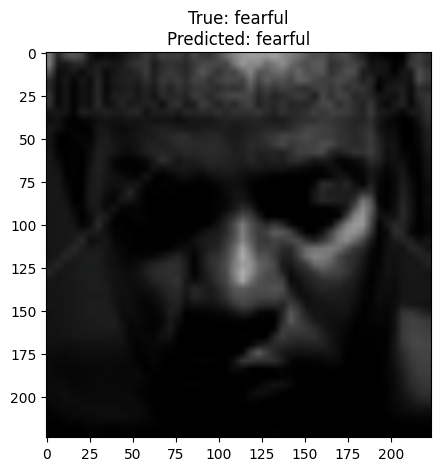

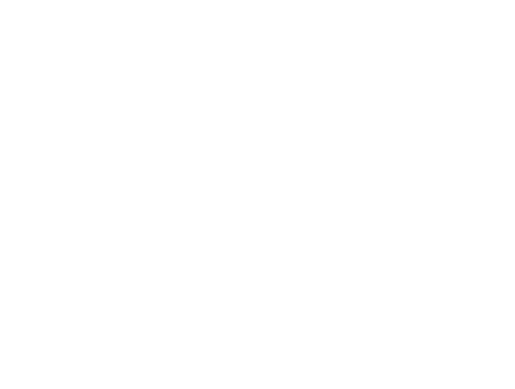

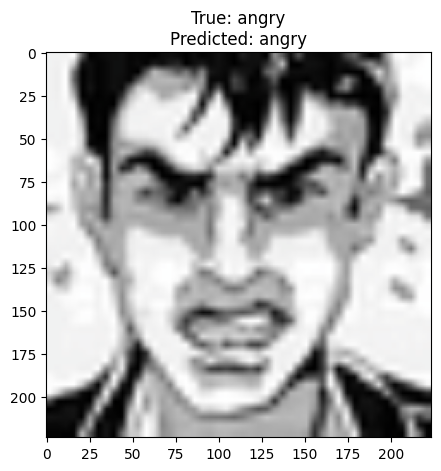

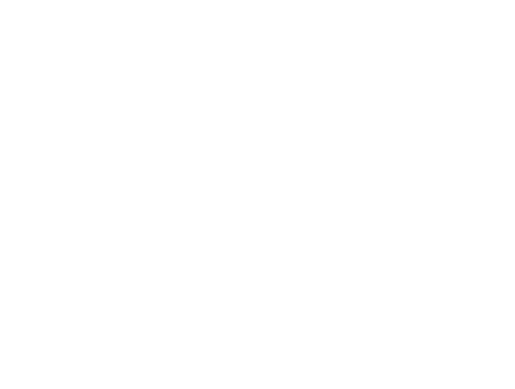

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated

def show_image_predictions(images, true_labels, predicted_labels, class_names):
    for i in range(5):  # Display the first 5 images
        img = images[i]
        true = true_labels[i]
        pred = predicted_labels[i]

        plt.figure(figsize=(5, 5))
        imshow(img, title=f'True: {class_names[true]}\nPredicted: {class_names[pred]}')
        plt.axis('off')
        plt.show()

# Assuming you have a function to denormalize your images if necessary
# images, true_labels, predicted_labels are loaded or computed previously
# class_names is a list of class names indexed according to your model's output

show_image_predictions(images, true_labels, preds, class_names)
